In [21]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport

df = pd.read_csv("data/gold.csv")
pd.set_option('display.max_columns', None)  

In [22]:
df_2010 = df[~df['InvoiceDate'].str.contains('2011')]
df_2011 = df[~df['InvoiceDate'].str.contains('2009|2010')]

In [23]:
df_2011

,Invoice,StockCode,Quantity,InvoiceDate,year,month,Price,Customer ID,Country,Total,total_facture,nombre_commande_client_années_2009,nombre_commande_client_années_2010,nombre_commande_client_années_2011,nombre_commande_client_années_annulées_2009,nombre_commande_client_années_annulées_2010,nombre_commande_client_années_annulées_2011,Continent,niveau_achat,Recency,Frequency,Frequency_reel,Montant
444383,539993,22386,10,2011-01-04,2011,1,1.95,13313.0,United Kingdom,19.50,307.30,3.0,7.0,5.0,1.0,2.0,0.0,United Kingdom,2.0,22,15.0,12.0,58556.28
444384,539993,21499,25,2011-01-04,2011,1,0.42,13313.0,United Kingdom,10.50,307.30,3.0,7.0,5.0,1.0,2.0,0.0,United Kingdom,2.0,22,15.0,12.0,58556.28
444385,539993,21498,25,2011-01-04,2011,1,0.42,13313.0,United Kingdom,10.50,307.30,3.0,7.0,5.0,1.0,2.0,0.0,United Kingdom,2.0,22,15.0,12.0,58556.28
444386,539993,22379,5,2011-01-04,2011,1,2.10,13313.0,United Kingdom,10.50,307.30,3.0,7.0,5.0,1.0,2.0,0.0,United Kingdom,2.0,22,15.0,12.0,58556.28
444387,539993,20718,10,2011-01-04,2011,1,1.25,13313.0,United Kingdom,12.50,307.30,3.0,7.0,5.0,1.0,2.0,0.0,United Kingdom,2.0,22,15.0,12.0,58556.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824342,581587,22899,6,2011-12-09,2011,12,2.10,12680.0,France,12.60,267.45,0.0,0.0,4.0,0.0,0.0,0.0,Europe,1.0,0,4.0,4.0,13193.46
824343,581587,23254,4,2011-12-09,2011,12,4.15,12680.0,France,16.60,267.45,0.0,0.0,4.0,0.0,0.0,0.0,Europe,1.0,0,4.0,4.0,13193.46
824344,581587,23255,4,2011-12-09,2011,12,4.15,12680.0,France,16.60,267.45,0.0,0.0,4.0,0.0,0.0,0.0,Europe,1.0,0,4.0,4.0,13193.46
824345,581587,22138,3,2011-12-09,2011,12,4.95,12680.0,France,14.85,267.45,0.0,0.0,4.0,0.0,0.0,0.0,Europe,1.0,0,4.0,4.0,13193.46


In [24]:
print(df.columns)

Index(['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'year', 'month',
       'Price', 'Customer ID', 'Country', 'Total', 'total_facture',
       'nombre_commande_client_années_2009',
       'nombre_commande_client_années_2010',
       'nombre_commande_client_années_2011',
       'nombre_commande_client_années_annulées_2009',
       'nombre_commande_client_années_annulées_2010',
       'nombre_commande_client_années_annulées_2011', 'Continent',
       'niveau_achat', 'Recency', 'Frequency', 'Frequency_reel', 'Montant'],
      dtype='object')


In [29]:
customer_ids_2010 = df_2010['Customer ID'].unique()
customer_ids_2011 = df_2011['Customer ID'].unique()
common_customer_ids = set(customer_ids_2010).intersection(customer_ids_2011)
df_2010 = df_2010[df_2010['Customer ID'].isin(common_customer_ids)]
df_2011 = df_2011[df_2011['Customer ID'].isin(common_customer_ids)]


In [30]:
df_2010

,Invoice,StockCode,Quantity,InvoiceDate,year,month,Price,Customer ID,Country,Total,total_facture,nombre_commande_client_années_2009,nombre_commande_client_années_2010,nombre_commande_client_années_2011,nombre_commande_client_années_annulées_2009,nombre_commande_client_années_annulées_2010,nombre_commande_client_années_annulées_2011,Continent,niveau_achat,Recency,Frequency,Frequency_reel,Montant
0,489434,85048,12,2009-12-01,2009,12,6.95,13085.0,United Kingdom,83.40,505.30,4.0,3.0,3.0,0.0,1.0,1.0,United Kingdom,2.0,157,10.0,8.0,27639.60
1,489434,79323P,12,2009-12-01,2009,12,6.75,13085.0,United Kingdom,81.00,505.30,4.0,3.0,3.0,0.0,1.0,1.0,United Kingdom,2.0,157,10.0,8.0,27639.60
2,489434,79323W,12,2009-12-01,2009,12,6.75,13085.0,United Kingdom,81.00,505.30,4.0,3.0,3.0,0.0,1.0,1.0,United Kingdom,2.0,157,10.0,8.0,27639.60
3,489434,22041,48,2009-12-01,2009,12,2.10,13085.0,United Kingdom,100.80,505.30,4.0,3.0,3.0,0.0,1.0,1.0,United Kingdom,2.0,157,10.0,8.0,27639.60
4,489434,21232,24,2009-12-01,2009,12,1.25,13085.0,United Kingdom,30.00,505.30,4.0,3.0,3.0,0.0,1.0,1.0,United Kingdom,2.0,157,10.0,8.0,27639.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444378,539988,84380,1,2010-12-23,2010,12,1.25,18116.0,United Kingdom,1.25,353.69,0.0,8.0,5.0,0.0,0.0,0.0,United Kingdom,3.0,67,13.0,13.0,113430.94
444379,539988,84849D,1,2010-12-23,2010,12,1.69,18116.0,United Kingdom,1.69,353.69,0.0,8.0,5.0,0.0,0.0,0.0,United Kingdom,3.0,67,13.0,13.0,113430.94
444380,539988,84849B,1,2010-12-23,2010,12,1.69,18116.0,United Kingdom,1.69,353.69,0.0,8.0,5.0,0.0,0.0,0.0,United Kingdom,3.0,67,13.0,13.0,113430.94
444381,539988,22854,2,2010-12-23,2010,12,4.95,18116.0,United Kingdom,9.90,353.69,0.0,8.0,5.0,0.0,0.0,0.0,United Kingdom,3.0,67,13.0,13.0,113430.94


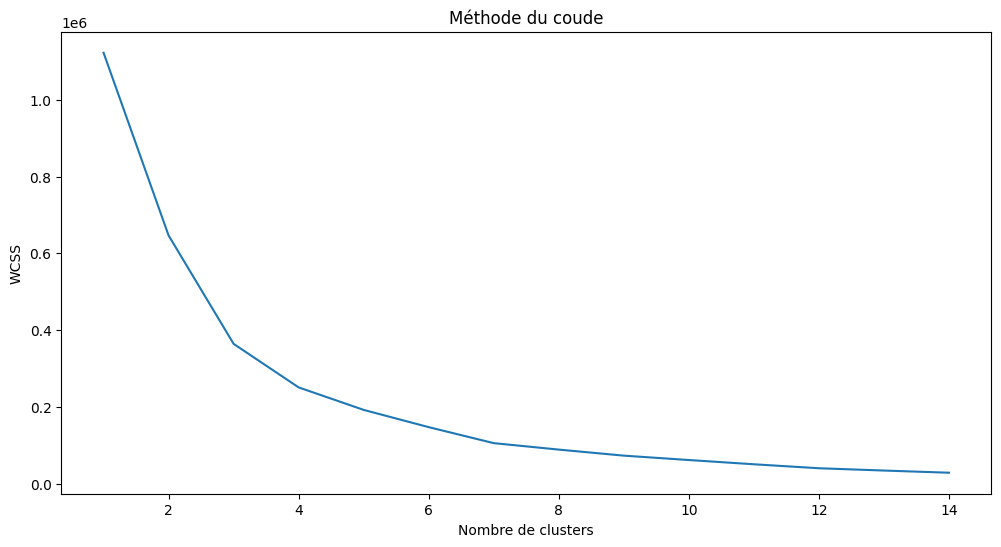

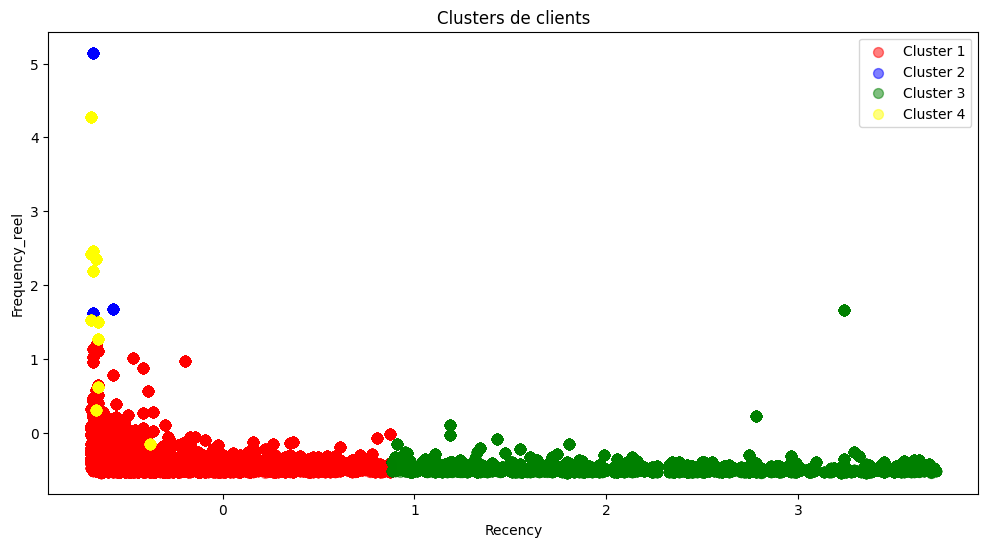

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Normalisation des données
scaler = StandardScaler()
data = scaler.fit_transform(df_2010[['Recency', 'Frequency_reel', 'Montant']])

# Détermination du nombre optimal de clusters en utilisant la méthode du coude
wcss = []
for i in range(1, 15):
 kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
 kmeans.fit(data)
 wcss.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(1, 15), wcss)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.show()

# Entraînement du modèle KMeans avec le nombre optimal de clusters
n_clusters = 4 # Remplacez cette valeur par le nombre optimal de clusters déterminé à l'aide de la méthode du coude
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(data)

# Visualisation des clusters
plt.figure(figsize=(12,6))
plt.scatter(data[pred_y == 0, 0], data[pred_y == 0, 1], s=50, c='red', label='Cluster 1', alpha=0.5)
plt.scatter(data[pred_y == 1, 0], data[pred_y == 1, 1], s=50, c='blue', label='Cluster 2', alpha=0.5)
plt.scatter(data[pred_y == 2, 0], data[pred_y == 2, 1], s=50, c='green', label='Cluster 3', alpha=0.5)
plt.scatter(data[pred_y == 3, 0], data[pred_y == 3, 1], s=50, c='yellow', label='Cluster 4', alpha=0.5)

# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')
plt.title('Clusters de clients')
plt.xlabel('Recency')
plt.ylabel('Frequency_reel')
plt.legend()
plt.show()

In [ ]:
# print(f"Longueur des étiquettes de cluster réelles: {len(labels_true)}")
# print(f"Longueur des étiquettes de cluster prédites: {len(labels_pred)}")

Longueur des étiquettes de cluster réelles: 1
Longueur des étiquettes de cluster prédites: 824347


In [37]:
from sklearn.metrics import adjusted_rand_score

# Remplacez les valeurs ci-dessous par les étiquettes de vos clusters
labels_true = [...] # Étiquettes de cluster réelles
labels_pred = kmeans.labels_ # Étiquettes de cluster prédites

# Calcul du score ARI
score = adjusted_rand_score(labels_true, labels_pred)

print(f"Le score ARI est: {score}")


ValueError: Found input variables with inconsistent numbers of samples: [1, 374130]

In [35]:
print(f"Longueur des étiquettes de cluster réelles: {len(labels_true)}")
print(f"Longueur des étiquettes de cluster prédites: {len(labels_pred)}")

Longueur des étiquettes de cluster réelles: 1
Longueur des étiquettes de cluster prédites: 374130
